In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

In [2]:
import dagshub

dagshub.init(repo_owner='joseadolfo1',
             repo_name='dsrptrabajofinalmle2',
             mlflow=True)

Accessing as joseadolfo1

Initialized MLflow to track repo "joseadolfo1/dsrptrabajofinalmle2"

Repository joseadolfo1/dsrptrabajofinalmle2 initialized!

In [3]:
mlflow.set_tracking_uri("https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow")

In [4]:
#mlflow.create_experiment("DSRP - Trabajo Final del Modulo MLE2")

In [5]:
mlflow.set_experiment("DSRP - Trabajo Final del Modulo MLE2")

<Experiment: artifact_location='mlflow-artifacts:/883b94a38b0545e2a993fd17d8d6ebc9', creation_time=1755968527946, experiment_id='0', last_update_time=1755968527946, lifecycle_stage='active', name='DSRP - Trabajo Final del Modulo MLE2', tags={}>

In [6]:
raw_pjme = pd.read_csv("../data/raw/PJME_hourly.csv",parse_dates=[0])

In [7]:
raw_pjme.columns[0]

'Datetime'

In [7]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [8]:
raw_pjme = raw_pjme.sort_index()

In [9]:
if raw_pjme.index.duplicated().any():
    raw_pjme = raw_pjme.groupby(level=0).mean().sort_index()

In [10]:
raw_pjme = raw_pjme.asfreq("h")

In [11]:
print(raw_pjme.isna().sum())

PJME_MW    30
dtype: int64


In [12]:
raw_pjme["PJME_MW"] = raw_pjme["PJME_MW"].interpolate()

In [15]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145392 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [9]:
print(raw_pjme.describe())

                            Datetime        PJME_MW
count                         145366  145366.000000
mean   2010-04-18 03:25:25.999202048   32080.222831
min              2002-01-01 01:00:00   14544.000000
25%              2006-02-23 14:15:00   27573.000000
50%              2010-04-18 04:30:00   31421.000000
75%              2014-06-10 18:45:00   35650.000000
max              2018-08-03 00:00:00   62009.000000
std                              NaN    6464.012166


In [14]:
print(raw_pjme.isna().sum())

PJME_MW    0
dtype: int64


<Axes: xlabel='Datetime', ylabel='PJME_MW'>

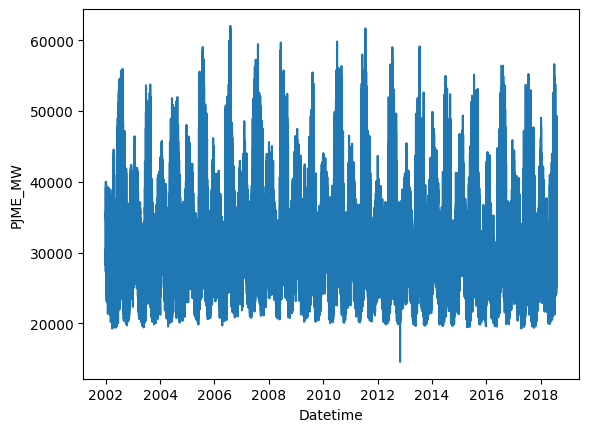

In [15]:
sns.lineplot(x=raw_pjme.index, y=raw_pjme["PJME_MW"])

In [16]:
train_raw_pjme = raw_pjme[:int(len(raw_pjme)*0.8)]
test_raw_pjme = raw_pjme[int(len(raw_pjme)*0.8):]

In [17]:
train_raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116313 entries, 2002-01-01 01:00:00 to 2015-04-09 09:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  116313 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [18]:
test_raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29079 entries, 2015-04-09 10:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  29079 non-null  float64
dtypes: float64(1)
memory usage: 454.4 KB


2025/08/23 13:14:59 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/23 13:14:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/23 13:14:59 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/23 13:14:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/23 13:14:59 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

🏃 View run Prophet - multiplicative at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/f57a83650b574419baac363990de50d2
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


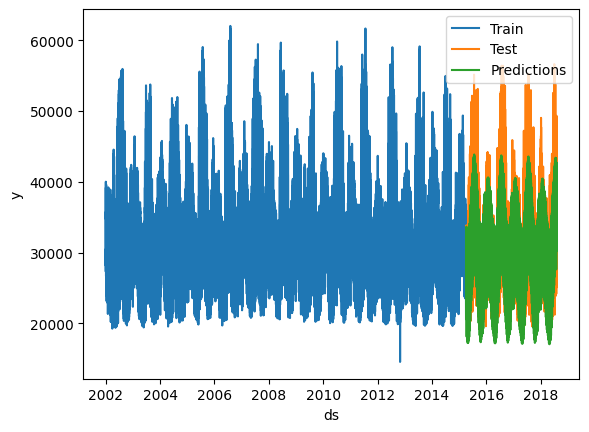

In [19]:
mlflow.autolog()
with mlflow.start_run(run_name="Prophet - multiplicative") as run:
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode="multiplicative"
        )
    
    train_raw_pjme = train_raw_pjme.reset_index()
    test_raw_pjme = test_raw_pjme.reset_index()
    
    train_raw_pjme.columns = ["ds", "y"]
    test_raw_pjme.columns = ["ds", "y"]
    
    train_raw_pjme["ds"] = pd.to_datetime(train_raw_pjme['ds'])
    test_raw_pjme["ds"] = pd.to_datetime(test_raw_pjme['ds'])
                                        
    model.fit(train_raw_pjme)
    predictions = model.predict(test_raw_pjme)
    y_pred = predictions['yhat'].values
        
    mae = mean_absolute_error(test_raw_pjme['y'], y_pred)
    mape = mean_absolute_percentage_error(test_raw_pjme['y'], y_pred)
    mse = mean_squared_error(test_raw_pjme['y'], y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)    
    
    sns.lineplot(x='ds', y='y', data=train_raw_pjme, label='Train')
    sns.lineplot(x='ds', y='y', data=test_raw_pjme, label='Test')
    sns.lineplot(x=test_raw_pjme['ds'], y=y_pred, label='Predictions')
    mlflow.log_figure(plt.gcf(), "Prophet_multiplicative.png")


In [20]:
train_raw_pjme = raw_pjme[:int(len(raw_pjme)*0.8)]
test_raw_pjme = raw_pjme[int(len(raw_pjme)*0.8):]

2025/08/23 13:18:25 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/23 13:18:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/23 13:18:25 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/23 13:18:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/23 13:18:25 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

🏃 View run Prophet - additive at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/99c9fb08e095455a91f8223467047c4e
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


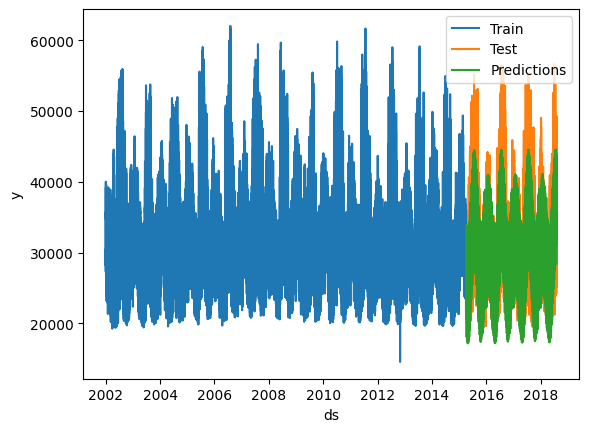

In [21]:
mlflow.autolog()
with mlflow.start_run(run_name="Prophet - additive") as run:
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode="additive"
        )
    
    train_raw_pjme = train_raw_pjme.reset_index()
    test_raw_pjme = test_raw_pjme.reset_index()
    
    train_raw_pjme.columns = ["ds", "y"]
    test_raw_pjme.columns = ["ds", "y"]
    
    train_raw_pjme["ds"] = pd.to_datetime(train_raw_pjme['ds'])
    test_raw_pjme["ds"] = pd.to_datetime(test_raw_pjme['ds'])
                                        
    model.fit(train_raw_pjme)
    predictions = model.predict(test_raw_pjme)
    y_pred = predictions['yhat'].values
        
    mae = mean_absolute_error(test_raw_pjme['y'], y_pred)
    mape = mean_absolute_percentage_error(test_raw_pjme['y'], y_pred)
    mse = mean_squared_error(test_raw_pjme['y'], y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)    
    
    
    sns.lineplot(x='ds', y='y', data=train_raw_pjme, label='Train')
    sns.lineplot(x='ds', y='y', data=test_raw_pjme, label='Test')
    sns.lineplot(x=test_raw_pjme['ds'], y=y_pred, label='Predictions')
    mlflow.log_figure(plt.gcf(), "Prophet_additive.png")



In [22]:
train_raw_pjme = raw_pjme[:int(len(raw_pjme)*0.8)]
test_raw_pjme = raw_pjme[int(len(raw_pjme)*0.8):]

2025/08/23 13:20:29 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/23 13:20:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/23 13:20:29 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/23 13:20:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/23 13:20:29 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

🏃 View run ETS at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/8a46e2de9fe24dedac0c7dd2bf35c2da
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


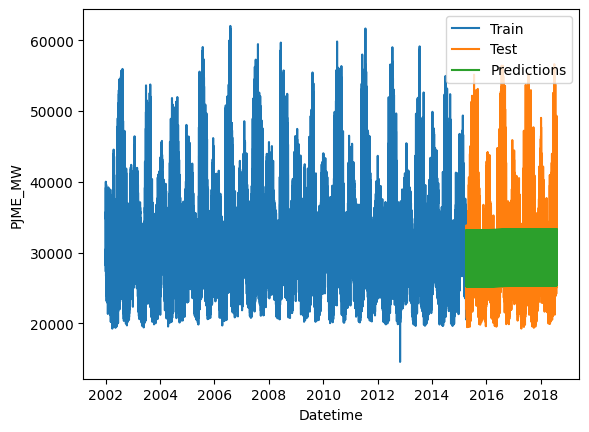

In [23]:
mlflow.autolog()
with mlflow.start_run(run_name="ETS") as run:
    
    model = ExponentialSmoothing(train_raw_pjme['PJME_MW'], trend='add', seasonal='add', seasonal_periods=24,initialization_method="estimated").fit()
    
    predictions = model.forecast(len(test_raw_pjme['PJME_MW']))
    
    mae = mean_absolute_error(test_raw_pjme['PJME_MW'], predictions)
    mape = mean_absolute_percentage_error(test_raw_pjme['PJME_MW'], predictions)
    mse = mean_squared_error(test_raw_pjme['PJME_MW'], predictions)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse) 
    
    
    sns.lineplot(x=train_raw_pjme.index, y='PJME_MW', data=train_raw_pjme, label='Train')
    sns.lineplot(x=test_raw_pjme.index, y='PJME_MW', data=test_raw_pjme, label='Test')
    sns.lineplot(x=test_raw_pjme.index, y=predictions, label='Predictions')
    
    mlflow.log_figure(plt.gcf(), "ETS.png")


In [24]:
xgboost_df = raw_pjme.copy()

In [25]:
xgboost_df = xgboost_df.reset_index()
xgboost_df.columns = ["ds", "y"]
xgboost_df

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


2025/08/23 13:21:28 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/23 13:21:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/23 13:21:28 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/23 13:21:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/23 13:21:28 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

🏃 View run XGBOOST at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/bcc91bd1ed7344cd9c49fe514326a60e
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


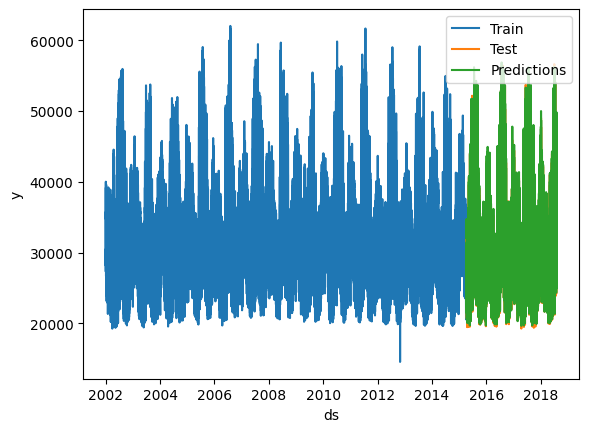

In [26]:
mlflow.autolog()
with mlflow.start_run(run_name="XGBOOST") as run:
    
    xgboost_df["LAG1"] = xgboost_df['y'].shift(1)
    xgboost_df["LAG2"] = xgboost_df['y'].shift(2)
    xgboost_df["LAG3"] = xgboost_df['y'].shift(3)
    xgboost_df["LAG4"] = xgboost_df['y'].shift(4)
    xgboost_df["ds"] = pd.to_datetime(xgboost_df['ds'])
    
    xgboost_df = xgboost_df.sort_values('ds').set_index('ds')
    
    x, y = xgboost_df.drop(['y'], axis=1), xgboost_df['y']
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2, random_state=42)
    
    
    xgb = XGBRegressor().fit(x_train, y_train)                          
    y_pred = xgb.predict(x_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    
    
    sns.lineplot(x=x_train.index, y=y_train,  label='Train')
    sns.lineplot(x=x_test.index, y=y_test, label='Test')
    sns.lineplot(x=x_test.index, y=y_pred, label='Predictions')

    mlflow.log_figure(plt.gcf(), "XGBOOST.png")


In [27]:
%pwd

'/home/joe/Documents/dsrptrabajofinalmle2/notebooks'